In [1]:
%cd ..

/data_diet


In [2]:
!ls exps

baseline		       keep_max_grad_norm_scores_20
keep_max_error_l2_norm_scores  keep_max_input_variance_scores
keep_max_grad_norm	       keep_max_noised_input_variance_scores
keep_max_grad_norm_scores


In [12]:
import numpy as np
import glob
import scipy.stats as stats

In [4]:
# load ckpt_0.npy
files = glob.glob('exps/baseline/*/ckpt_*.npy')
print(files)
# load the files
files = {f: np.load(f, allow_pickle=True) for f in files}
# extract the two patterns from the filenames
files = {(f.split('/')[-2], int(f.split('/')[-1].split('_')[-1].split('.')[0])): v for f, v in files.items()}

['exps/baseline/grad_norm_scores/ckpt_0.npy', 'exps/baseline/grad_norm_scores/ckpt_7800.npy', 'exps/baseline/error_l2_norm_scores/ckpt_7800.npy', 'exps/baseline/noised_input_variance_scores/ckpt_0.npy', 'exps/baseline/input_variance_scores/ckpt_0.npy', 'exps/baseline/forget_scores/ckpt_78000.npy']


In [5]:
files.keys()

dict_keys([('grad_norm_scores', 0), ('grad_norm_scores', 7800), ('error_l2_norm_scores', 7800), ('noised_input_variance_scores', 0), ('input_variance_scores', 0), ('forget_scores', 78000)])

In [6]:
all_scores = files

In [7]:
input_norm_scores = all_scores[('input_variance_scores', 0)]
noised_input_norm_scores = all_scores[('noised_input_variance_scores', 0)]
grad_norm_scores = all_scores[('grad_norm_scores', 0)]
late_grad_norm_scores = all_scores[('grad_norm_scores', 7800)]
l2_error_scores = all_scores[('error_l2_norm_scores', 7800)]
forget_scores = all_scores[('forget_scores', 78000)]

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from copy import copy

# set seaborn style
sns.set_style("white")
# make the background opaque
#sns.set(rc={'figure.facecolor':'white', 'figure.edgecolor':'white'})

In [9]:
def normalize(x):
    return (x - np.min(x))/(np.max(x)-np.min(x))

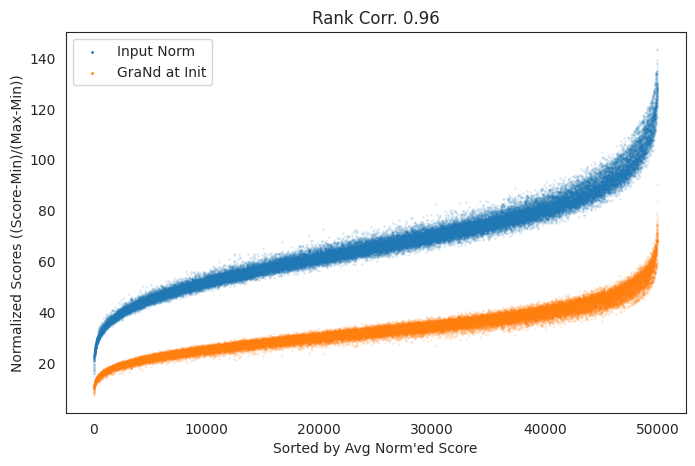

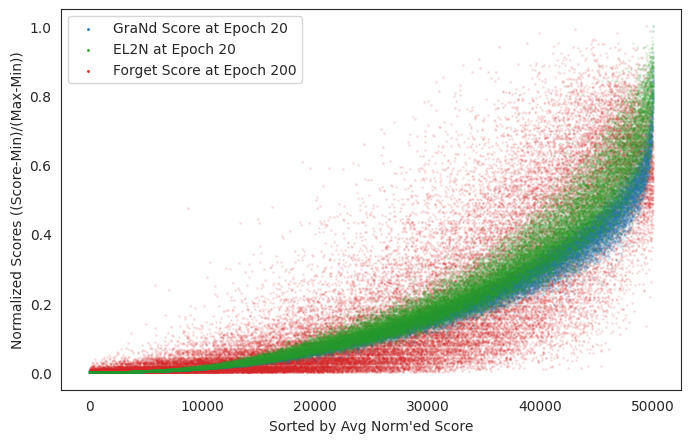

In [33]:
# plot both scores in the same plot. sort by scores
sorted_indices = np.argsort(normalize(grad_norm_scores)+normalize(input_norm_scores))

plt.figure(figsize=(8,8/1.618))

plt.scatter(range(len(sorted_indices)), normalize(input_norm_scores[sorted_indices]), alpha=0.1, color='C0', label='Input Norm', s=1, zorder=3)
plt.scatter(range(len(sorted_indices)), normalize(grad_norm_scores[sorted_indices]), alpha=0.1, s=1, label='GraNd at Init', color='C1', zorder=2)

#plt.scatter(range(len(sorted_indices)), normalize(late_grad_norm_scores[sorted_indices]), alpha=0.1, s=1, label='GraNd at Epoch 20', color='C4', zorder=1)

plt.ylabel('Normalized Scores ((Score-Min)/(Max-Min))')
plt.xlabel('Sorted by Avg Norm\'ed Score')

# Spearman rank correlation in title
plt.title(f'Rank Corr. {stats.spearmanr(grad_norm_scores, input_norm_scores)[0]:.2f}')

#plt.scatter(range(len(sorted_indices)), noised_input_norm_scores[sorted_indices], alpha=0.1, color='C0', label='noised_input_norm_scores', s=1)

def make_legend_lines_opaque():
    lines, labels = plt.gca().get_legend_handles_labels()

    lines = lines
    labels = labels
    lines = [copy(l) for l in lines]
    for l in lines:
        l.set_alpha(1)
        
    plt.legend(lines, labels, loc=0)
        
make_legend_lines_opaque()

# plt.savefig('grad_norm_scores_at_init_vs_late_vs_input_norm.svg',
#             bbox_inches='tight', pad_inches=0, transparent=True)
plt.savefig('grad_norm_scores_at_init_vs_late_vs_input_norm.png', dpi=300,
            bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()

plt.figure(figsize=(8,8/1.618))

sorted_indices = np.argsort(normalize(late_grad_norm_scores)+normalize(l2_error_scores)+normalize(late_grad_norm_scores))

plt.scatter(range(len(sorted_indices)), normalize(late_grad_norm_scores[sorted_indices]), alpha=0.1, s=1, label='GraNd Score at Epoch 20', color="C0",zorder=2)
plt.scatter(range(len(sorted_indices)), normalize(l2_error_scores[sorted_indices]), alpha=0.1, s=1, label='EL2N at Epoch 20', color='C2', zorder=2)
plt.scatter(range(len(sorted_indices)), normalize(forget_scores[sorted_indices]), alpha=0.1, s=1, label='Forget Score at Epoch 200', color="C3", zorder=1)

plt.ylabel('Normalized Scores ((Score-Min)/(Max-Min))')
plt.xlabel('Sorted by Avg Norm\'ed Score')

make_legend_lines_opaque()

# plt.savefig('el2n_vs_forget_vs_grand_at_20.svg',
#             bbox_inches='tight', pad_inches=0, transparent=True)
plt.savefig('el2n_vs_forget_vs_grand_at_20.png', dpi=300,
            bbox_inches='tight', pad_inches=0, transparent=True)

plt.show()


In [41]:
import scipy.stats as stats

In [42]:
# Compute Spearman rank correlation from scipy

print('Correlations at epoch 0:')
print(f"{stats.spearmanr(input_norm_scores, grad_norm_scores)[0]=}")
print(f"{stats.spearmanr(noised_input_norm_scores, grad_norm_scores)[0]=}")
print()
print('Correlations between epochs 0 and 20:')
print(f"{stats.spearmanr(grad_norm_scores, late_grad_norm_scores)[0]=}")
print(f"{stats.spearmanr(grad_norm_scores, forget_scores)[0]=}")
print()
print('Correlations at epoch 20:')
print(f"{stats.spearmanr(late_grad_norm_scores, forget_scores)[0]=}")
print(f"{stats.spearmanr(forget_scores, l2_error_scores)[0]=}")
print(f"{stats.spearmanr(late_grad_norm_scores, l2_error_scores)[0]=}")


Correlations at epoch 0:
stats.spearmanr(input_norm_scores, grad_norm_scores)[0]=0.9630030296956291
stats.spearmanr(noised_input_norm_scores, grad_norm_scores)[0]=0.9307928920951674

Correlations between epochs 0 and 20:
stats.spearmanr(grad_norm_scores, late_grad_norm_scores)[0]=-0.024219335044960225
stats.spearmanr(grad_norm_scores, forget_scores)[0]=-0.02341931379448561

Correlations at epoch 20:
stats.spearmanr(late_grad_norm_scores, forget_scores)[0]=0.8677243834267727
stats.spearmanr(forget_scores, l2_error_scores)[0]=0.8937207451994732
stats.spearmanr(late_grad_norm_scores, l2_error_scores)[0]=0.9851926691947452


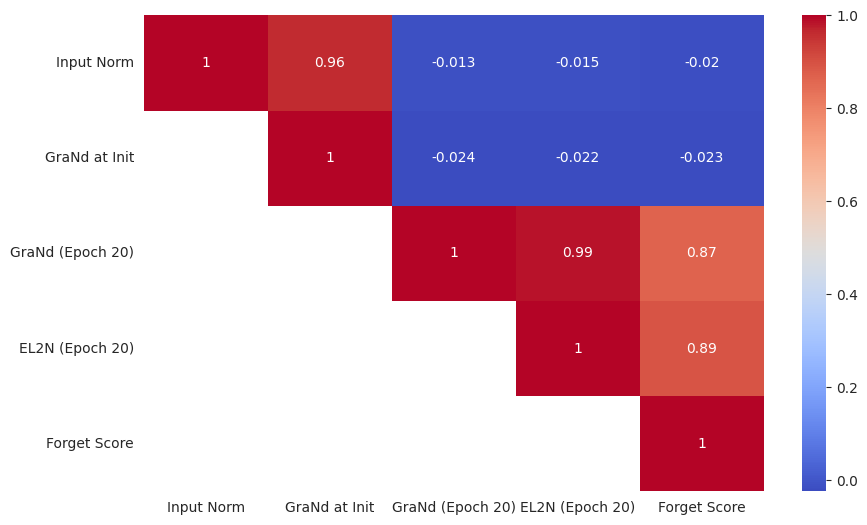

In [32]:
# Creata "rank correlation" table between input norm, grad_norm, late_grad_norm, forget_scores, and l2_error_scores 
import pandas as pd

# Create a dataframe with the correlations
corr_df = pd.DataFrame({'Input Norm': input_norm_scores,
                        'GraNd at Init': grad_norm_scores,
                        'GraNd (Epoch 20)': late_grad_norm_scores,
                        'EL2N (Epoch 20)': l2_error_scores,
                        'Forget Score': forget_scores,
                        })


# Create a "rank correlation" table between input norm, grad_norm, late_grad_norm, forget_scores, and l2_error_scores 
rcorrs = corr_df.corr(method='spearman')

# Remove all columns with column index greater row index
rcorrs = rcorrs.where(np.triu(np.ones(rcorrs.shape)).astype(bool))

#rcorrs = rcorrs.where(~np.triu(np.ones(rcorrs.shape)).astype(bool))

# Plot the heatmap
plt.figure(figsize=(10,10/1.618))
sns.heatmap(rcorrs, annot=True, cmap='coolwarm')
plt.savefig('orgrepo_rankcorrelation_heatmap.pdf',
            bbox_inches='tight', pad_inches=0, transparent=True)
# plt.savefig('orgrepo_rankcorrelation_heatmap.png', dpi=300,
#             bbox_inches='tight', pad_inches=0, transparent=True)
plt.show()